In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import torchvision.models as models
import time
import os
import shutil
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageChops, ImageEnhance
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.utils import make_grid
import random
from IPython.display import clear_output

In [ ]:
#mount content from google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#list content in the selected google drive directory
!ls /content/drive/MyDrive/casia

Au  au_list.txt  test  Tp  tp_list.txt	train  val


In [ ]:
# Define paths
data_dir = '/content/drive/MyDrive/casia'
authentic_path = '/content/drive/MyDrive/casia/Au'
forged_path = '/content/drive/MyDrive/casia/Tp'


In [ ]:
target_size = (64, 64)

In [ ]:
# def convert_to_ela_image(data_dir, quality):
#     original_image = Image.open(data_dir).convert('RGB')
#     resaved_file_name = 'resaved_image.jpg'
#     original_image.save(resaved_file_name, 'JPEG', quality=quality)
#     resaved_image = Image.open(resaved_file_name)
#     ela_image = ImageChops.difference(original_image, resaved_image)
#     extrema = ela_image.getextrema()
#     max_difference = max([pix[1] for pix in extrema])
#     if max_difference == 0:
#         max_difference = 1
#     scale = 350.0 / max_difference
#     ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
#     ela_image.save("ela_image.png")
#     return ela_image

from PIL import Image, ImageChops, ImageEnhance

def convert_to_ela_image(image_path, quality=90):
    original_image = Image.open(image_path).convert('RGB')
    resaved_file_name = 'resaved_image.jpg'
    original_image.save(resaved_file_name, 'JPEG', quality=quality)
    resaved_image = Image.open(resaved_file_name)
    ela_image = ImageChops.difference(original_image, resaved_image)
    extrema = ela_image.getextrema()
    max_difference = max([pix[1] for pix in extrema])
    if max_difference == 0:
        max_difference = 1
    scale = 255.0 / max_difference
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    return ela_image

In [ ]:
# Function to load and transform images with ELA conversion
def load_and_transform_image(image_path, transform, target_size):
    ela_image = convert_to_ela_image(image_path)
    ela_image = ela_image.resize(target_size) # Resize the image
    ela_image = transform(ela_image)
    return ela_image

In [ ]:
# Define data augmentation transformations
transform = transforms.Compose([
    transforms.RandomCrop(target_size),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

In [ ]:
target_size = (64, 64)

In [ ]:
# Split the dataset
X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size=0.05, random_state=5)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.2, random_state=5)

# Create DataLoader
train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)
test_dataset = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Assuming Y_train is your training labels tensor
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(Y_train), y=Y_train.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [ ]:
# Load the pretrained VGG16 model
model = models.vgg16(pretrained=True)

# Freeze all the parameters in the model
for param in model.parameters():
    param.requires_grad = True

# Get the number of input features to the classifier
num_ftrs = model.classifier[6].in_features

# Replace the final layer of the classifier with a new layer for binary classification
model.classifier[6] = nn.Linear(num_ftrs, 2)

# Ensure the final layer's parameters require gradients
for param in model.classifier[6].parameters():
    param.requires_grad = True


# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 217MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=1e-4)

In [ ]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return running_loss / len(train_loader), 100 * correct / total

In [ ]:
def evaluate(model, device, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(val_loader), 100 * correct / total

In [ ]:
num_epochs = 30
device = 'cuda'
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []  # Corrected initialization

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, device, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, device, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

Epoch 1/30, Train Loss: 0.4895, Train Acc: 77.14%, Val Loss: 0.4357, Val Acc: 81.17%
Epoch 2/30, Train Loss: 0.4464, Train Acc: 78.57%, Val Loss: 0.4453, Val Acc: 79.30%
Epoch 3/30, Train Loss: 0.4329, Train Acc: 79.26%, Val Loss: 0.4234, Val Acc: 80.78%
Epoch 4/30, Train Loss: 0.4208, Train Acc: 79.42%, Val Loss: 0.4243, Val Acc: 80.62%
Epoch 5/30, Train Loss: 0.4243, Train Acc: 79.67%, Val Loss: 0.4101, Val Acc: 81.17%
Epoch 6/30, Train Loss: 0.4138, Train Acc: 79.89%, Val Loss: 0.4067, Val Acc: 81.44%
Epoch 7/30, Train Loss: 0.4093, Train Acc: 80.04%, Val Loss: 0.4174, Val Acc: 80.45%
Epoch 8/30, Train Loss: 0.4064, Train Acc: 80.20%, Val Loss: 0.4076, Val Acc: 81.88%
Epoch 9/30, Train Loss: 0.4063, Train Acc: 79.98%, Val Loss: 0.4113, Val Acc: 80.45%
Epoch 10/30, Train Loss: 0.4038, Train Acc: 80.44%, Val Loss: 0.4103, Val Acc: 80.34%
Epoch 11/30, Train Loss: 0.4055, Train Acc: 80.46%, Val Loss: 0.4067, Val Acc: 81.33%
Epoch 12/30, Train Loss: 0.3987, Train Acc: 80.39%, Val Loss: 0

In [ ]:
test_loss, test_acc = evaluate(model, device, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

Test Loss: 0.3865, Test Acc: 80.96%


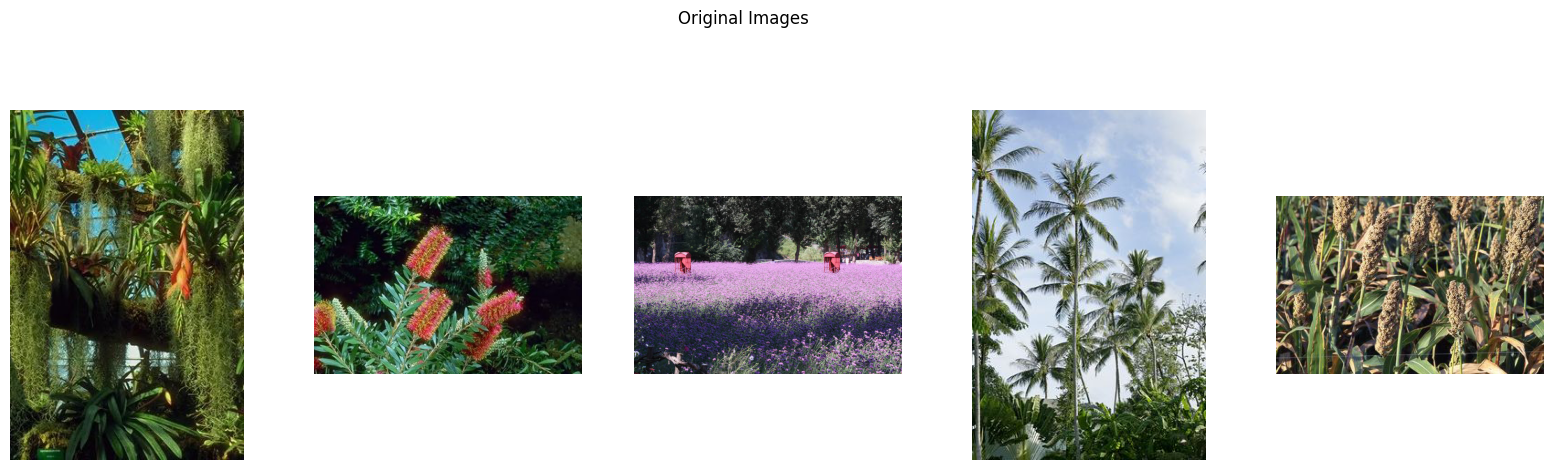

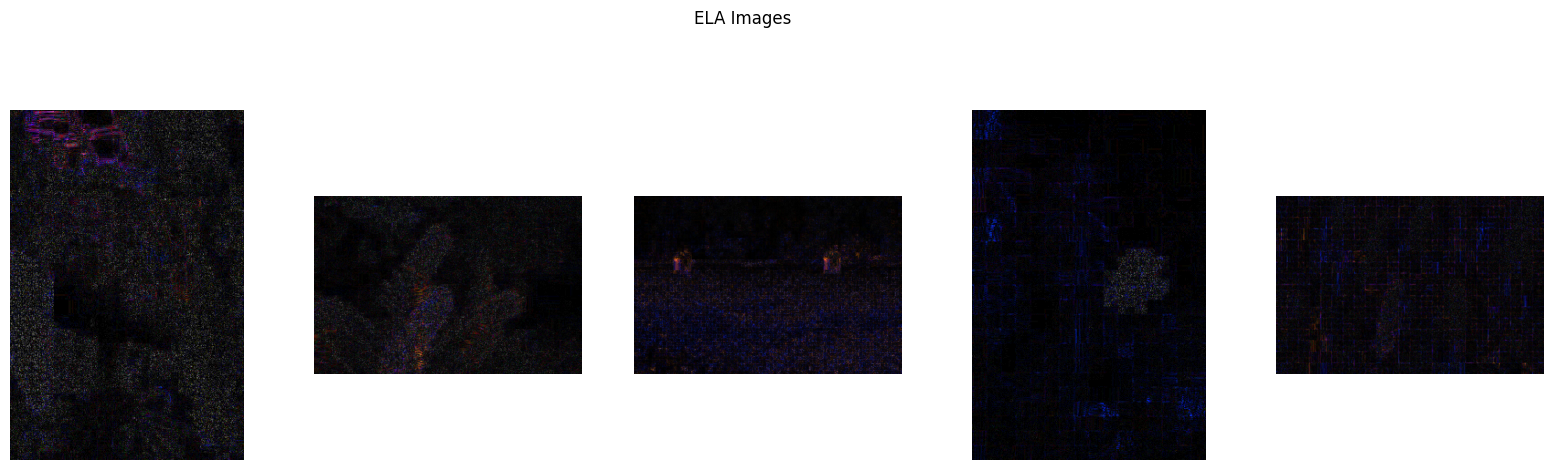

In [ ]:
def display_images(images, title):
    plt.figure(figsize=(20, 10))
    for i in range(len(images)):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Display original images
original_images = [Image.open(os.path.join(forged_path, filename)).convert('RGB') for filename in os.listdir(forged_path)[:5]]
display_images(original_images, "Original Images")

# Display ELA images
ela_images = [convert_to_ela_image(os.path.join(forged_path, filename), 90) for filename in os.listdir(forged_path)[:5]]
display_images(ela_images, "ELA Images")

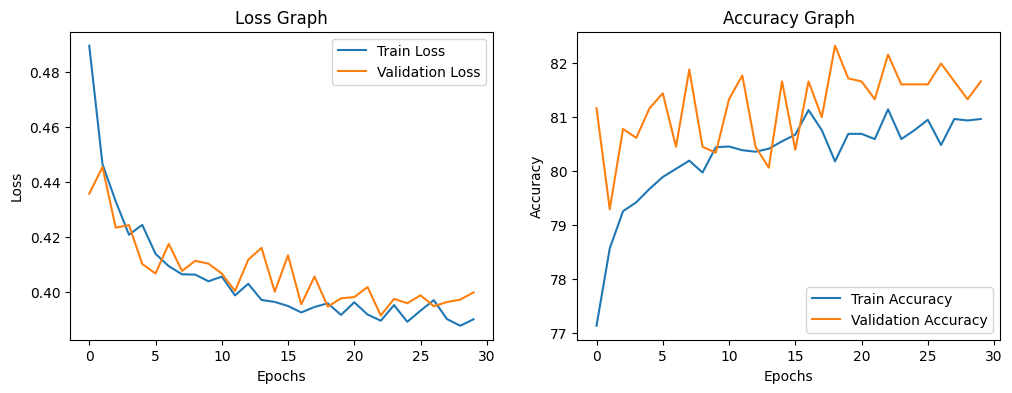

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Graph')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Graph')

plt.show()

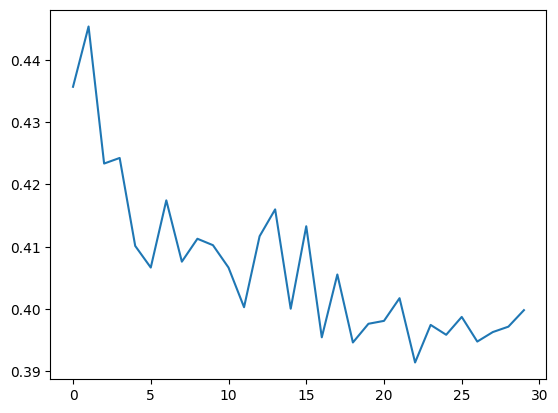

In [ ]:
plt.plot(val_losses, label='Validation Loss')

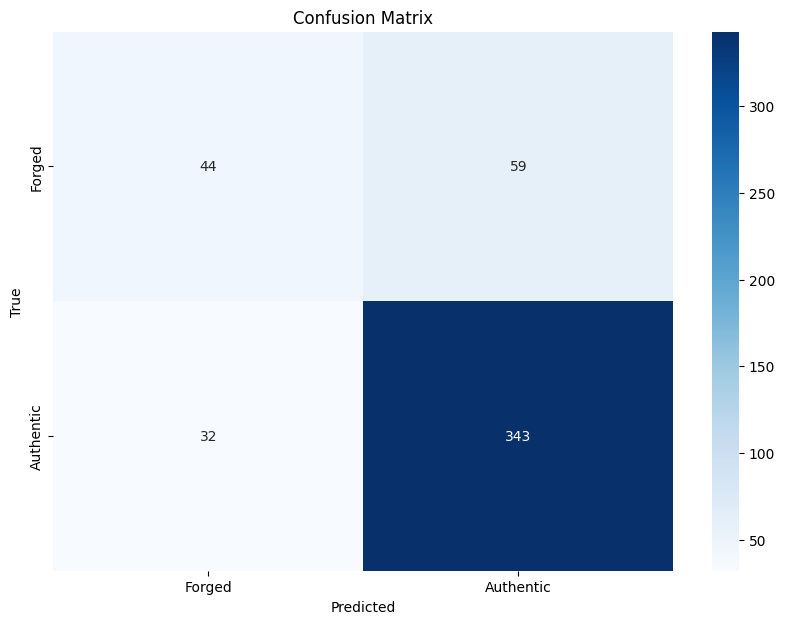

              precision    recall  f1-score   support

      Forged       0.58      0.43      0.49       103
   Authentic       0.85      0.91      0.88       375

    accuracy                           0.81       478
   macro avg       0.72      0.67      0.69       478
weighted avg       0.79      0.81      0.80       478



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Forged', 'Authentic'], yticklabels=['Forged', 'Authentic'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=['Forged', 'Authentic']))

In [ ]:
# List all files in the test directory
test_image_files = os.listdir(test_dir)

# Select the first image file (or any specific image file you want to test)
test_image_path = os.path.join(test_dir, test_image_files[4])

In [ ]:
 # Replace with your test image path
test_image = prepare_image(test_image_path )
test_image = test_image.reshape(-1, 128, 128, 3)
test_image_tensor = torch.tensor(test_image, dtype=torch.float32).permute(0, 3, 1, 2).to(device)

model.eval()
with torch.no_grad():
    y_pred = model(test_image_tensor)
    y_pred_class = torch.argmax(y_pred, dim=1).cpu().numpy()[0]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Display original image
original_image = plt.imread(test_image_path)
ax[0].axis('off')
ax[0].imshow(original_image)
ax[0].set_title('Original Image')

# Display ELA applied image
ax[1].axis('off')
ax[1].imshow(convert_to_ela_image(test_image_path, 90))
ax[1].set_title('ELA Image')

class_names = ['Forged', 'Authentic']
print(f'Prediction: {class_names[y_pred_class]}')

In [ ]:
class_names = ['Forged', 'Authentic']

# Testing accuracy
correct_test = 0  # correctly predicted test images
total_test = 0    # total test images

# Ensure the model is in evaluation mode
model.eval()

# Iterate over the test data
for index, image in enumerate(tqdm(X_test, desc="Processing Images : ")):
    # Reshape the image to match the input shape expected by the model
    image = image.reshape(-1, 128, 128, 3)
    image_tensor = torch.tensor(image, dtype=torch.float32).permute(0, 3, 1, 2).to(device)

    # Make prediction
    with torch.no_grad():
        y_pred = model(image_tensor)
        y_pred_class = torch.argmax(y_pred, dim=1).cpu().numpy()[0]

    # Update total test images count
    total_test += 1

    # Check if the prediction is correct
    if y_pred_class == Y_test[index]:
        correct_test += 1

# Calculate accuracy
accuracy = correct_test / total_test * 100.0
print(f'Total test images: {total_test}\nCorrectly predicted images: {correct_test}\nAccuracy: {accuracy:.2f} %')

In [ ]:
from PIL import Image

# Initialize counters
authentic, forged, total = 0, 0, 0

# Define the path to the test directory
test_folder_path = '/content/drive/MyDrive/casia/test'

# Function to prepare images
def prepare_image(image_path, target_size=(128, 128)):
    with Image.open(image_path) as img:
        img = img.convert('RGB')  # Ensure 3 color channels
        img = img.resize(target_size)  # Resize image
        return np.array(img)

# Iterate over files in the test directory
for filename in tqdm(os.listdir(test_folder_path), desc="Processing Images : "):
    if filename.endswith('jpg') or filename.endswith('png'):
        test_image_path = os.path.join(test_folder_path, filename)
        test_image = prepare_image(test_image_path)
        test_image = test_image.reshape(-1, 128, 128, 3)
        test_image_tensor = torch.tensor(test_image, dtype=torch.float32).permute(0, 3, 1, 2).to(device)

        # Make prediction
        model.eval()
        with torch.no_grad():
            y_pred = model(test_image_tensor)
            y_pred_class = torch.argmax(y_pred, dim=1).cpu().numpy()[0]

        # Update counters
        total += 1
        if y_pred_class == 0:
            forged += 1
        else:
          authentic += 1

# Print results
print(f'Total images: {total}\nAuthentic Images: {authentic}\nForged Images: {forged}')

In [ ]:
# Initialize counters and lists
authentic, forged, total = 0, 0, 0
forged_indices = []  # Initialize the list to store indices of forged images

# Function to prepare images
def prepare_image(image_path, target_size=(128, 128)):
    with Image.open(image_path) as img:
        img = img.convert('RGB')  # Ensure 3 color channels
        img = img.resize(target_size)  # Resize image
        return np.array(img)

# Iterate over files in the test directory
for index, filename in enumerate(tqdm(os.listdir(test_folder_path), desc="Processing Images : ")):
    if filename.endswith('jpg') or filename.endswith('png'):
        test_image_path = os.path.join(test_folder_path, filename)
        test_image = prepare_image(test_image_path)
        test_image = test_image.reshape(-1, 128, 128, 3)
        test_image_tensor = torch.tensor(test_image, dtype=torch.float32).permute(0, 3, 1, 2).to(device)

        # Make prediction
        model.eval()
        with torch.no_grad():
            y_pred = model(test_image_tensor)
            y_pred_class = torch.argmax(y_pred, dim=1).cpu().numpy()[0]

        # Update counters and store indices
        total += 1
        if y_pred_class == 0:
            forged += 1
            forged_indices.append(index)
        else:
            authentic += 1

# Print results
print(f'Total images: {total}\nAuthentic Images: {authentic}\nForged Images: {forged}')
print(f'Indices of forged images: {forged_indices}')